# Load the required libraries

In [ ]:
# Below code imports all the required libraries that we will be using further in the assignment
import keras
from tensorflow.python.client import device_lib
import numpy as np
import pandas
import pandas as pd
import tensorflow as tf
from collections import defaultdict
import re
import sys
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from sklearn.metrics import classification_report, roc_curve, auc
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE


#NlTK

from wordcloud import WordCloud,STOPWORDS
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


#For Model

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D,ConvLSTM2D,Conv3D
from keras.layers import Reshape, Flatten, Dropout, Concatenate,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.initializers import Constant

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Mount google drive and load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# File paths for the datasets
train_file_path = '/content/drive/MyDrive/nlp_project/all_train.tsv'
validation_file_path = '/content/drive/MyDrive/nlp_project/all_validate.tsv'

# Loading the training dataset
mydata_train = pd.read_csv(train_file_path, sep='\t')

# Loading the validation dataset
mydata_validation = pd.read_csv(validation_file_path, sep='\t')


# Explore the Data

In [ ]:
# Print the first five rows of the data
mydata_train.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,0,0,NaN,NaN,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,1,1,155885.0,714550.0,RickSisco,NaN,1.443822e+09,NaN,True,cvm5uy4,http://i.imgur.com/yxrkYT8.jpg,3n7fld,NaN,5,psbattle_artwork,NaN,NaN,0,2,4
2,2,2,NaN,NaN,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
3,3,3,NaN,NaN,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
4,4,4,282323.0,1228398.0,NaN,NaN,1.378792e+09,NaN,True,cc5cbon,http://i.imgur.com/M8KTWMx.jpg,1lz1q0,NaN,3,psbattle_artwork,NaN,NaN,0,2,4


In [ ]:
# Understand the various columns and its datatypes and null values in each column
mydata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878218 entries, 0 to 878217
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0.2          878218 non-null  int64  
 1   Unnamed: 0            878218 non-null  int64  
 2   Unnamed: 0.1          242100 non-null  float64
 3   Unnamed: 0.1.1        242100 non-null  float64
 4   author                729472 non-null  object 
 5   clean_title           802789 non-null  object 
 6   created_utc           878218 non-null  float64
 7   domain                636118 non-null  object 
 8   hasImage              878218 non-null  bool   
 9   id                    878218 non-null  object 
 10  image_url             637564 non-null  object 
 11  linked_submission_id  242100 non-null  object 
 12  num_comments          636118 non-null  float64
 13  score                 878218 non-null  int64  
 14  subreddit             878218 non-null  object 
 15  

In [ ]:
# Checking the total null values in each column
mydata_train.isna().sum()

Unnamed: 0.2                 0
Unnamed: 0                   0
Unnamed: 0.1            636118
Unnamed: 0.1.1          636118
author                  148746
clean_title              75429
created_utc                  0
domain                  242100
hasImage                     0
id                           0
image_url               240654
linked_submission_id    636118
num_comments            242100
score                        0
subreddit                    0
title                    73840
upvote_ratio            242100
2_way_label                  0
3_way_label                  0
6_way_label                  0
dtype: int64

<ipython-input-84-48ac8c02e241>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(mydata_train.corr());


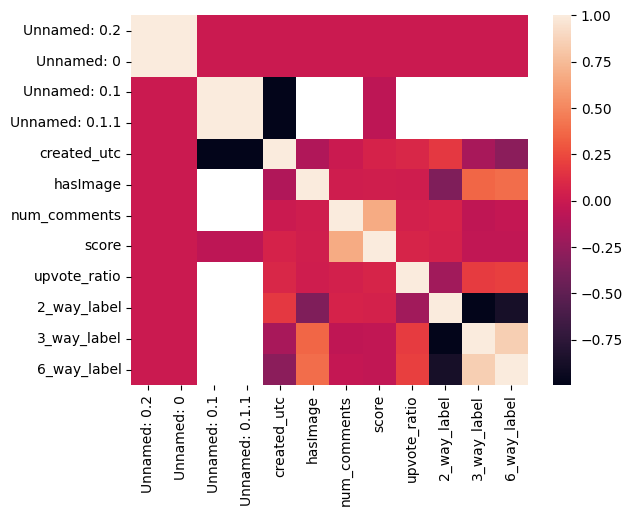

In [ ]:
# Corelation map to understand how columns are connected with label
sns.heatmap(mydata_train.corr());

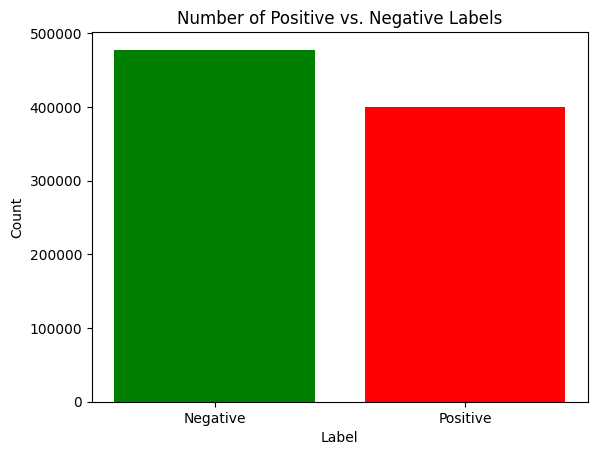

In [ ]:
# Count the number of positive and negative labels
label_counts = mydata_train['2_way_label'].value_counts()

# Plotting the bar graph
plt.bar(label_counts.index, label_counts.values, color=['green', 'red'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Number of Positive vs. Negative Labels')
plt.xticks(label_counts.index, ['Negative', 'Positive'])
plt.show()

In [ ]:
mydata_train_1=mydata_train.iloc[:,[5,7,8,10,12,13,17]]
mydata_train_1=mydata_train_1.iloc[:,:]
mydata_train_1.head()

,clean_title,domain,hasImage,image_url,num_comments,score,2_way_label
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,https://external-preview.redd.it/WylDbZrnbvZdB...,2.0,12,1
1,NaN,NaN,True,http://i.imgur.com/yxrkYT8.jpg,NaN,5,0
2,this concerned sink with a tiny hat,i.redd.it,True,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,2.0,119,0
3,hackers leak emails from uae ambassador to us,aljazeera.com,True,https://external-preview.redd.it/6fNhdbc6K1vFA...,1.0,44,1
4,NaN,NaN,True,http://i.imgur.com/M8KTWMx.jpg,NaN,3,0


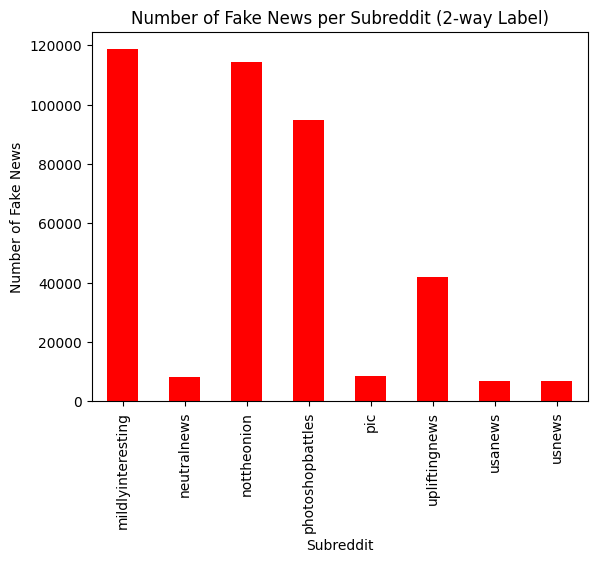

In [ ]:
# Filter out NaN values in the 'subreddit' and '2_way_label' columns
mydata_train_filtered = mydata_train.dropna(subset=['subreddit', '2_way_label'])

# Group by subreddit and calculate the number of fake news (2_way_label == 1)
fake_news_count = mydata_train_filtered [mydata_train_filtered ['2_way_label'] == 1].groupby('subreddit').size()

# Plotting the bar graph
fake_news_count.plot(kind='bar', color='red')
plt.xlabel('Subreddit')
plt.ylabel('Number of Fake News')
plt.title('Number of Fake News per Subreddit (2-way Label)')
plt.show()

In [ ]:
# Vlidation data
mydata_validation.head()

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,0,0,71235.0,316517.0,xprmntng,NaN,1.499964e+09,NaN,True,dk69gv8,https://i.imgur.com/snZdHrF.jpg,6n1oet,NaN,505,psbattle_artwork,NaN,NaN,0,2,4
1,1,1,NaN,NaN,singingdart7854,my xbox controller says hi,1.567436e+09,i.redd.it,True,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,NaN,4.0,25,mildlyinteresting,My Xbox controller says hi,0.72,1,0,0
2,2,2,NaN,NaN,mandal0re,new image from the mandalorian,1.567745e+09,i.imgur.com,True,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,NaN,5.0,21,photoshopbattles,PsBattle: New image from The Mandalorian,0.92,1,0,0
3,3,3,126554.0,582609.0,HE_WHO_DRUELS,say hello to my little friend,1.461468e+09,NaN,True,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg,4g6bp9,NaN,10,psbattle_artwork,Say hello to my little friend!,NaN,0,2,4
4,4,4,228704.0,1014196.0,eNaRDe,watch your step little one,1.408047e+09,NaN,True,cjqctpw,http://i.imgur.com/KRyMjn1.jpg,2diyh3,NaN,1,psbattle_artwork,Watch your step little one,NaN,0,2,4


In [ ]:
# Selecting a subset of the validation data
mydata_validation_1= mydata_validation.iloc[:,[5,7,8,10,12,13,17 ]]
mydata_validation_1=mydata_validation_1.iloc[:,:]
mydata_validation_1.head()

,clean_title,domain,hasImage,image_url,num_comments,score,2_way_label
0,NaN,NaN,True,https://i.imgur.com/snZdHrF.jpg,NaN,505,0
1,my xbox controller says hi,i.redd.it,True,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,4.0,25,1
2,new image from the mandalorian,i.imgur.com,True,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,5.0,21,1
3,say hello to my little friend,NaN,True,http://i.imgur.com/F1Zbl3D.jpg,NaN,10,0
4,watch your step little one,NaN,True,http://i.imgur.com/KRyMjn1.jpg,NaN,1,0


In [ ]:

def replace_nan_values(df):

    # Replace NaN values in string columns with ' '
    string_columns = df.select_dtypes(include=['object']).columns
    df[string_columns] = df[string_columns].fillna(' ')

    # Replace NaN values in integer columns with 0
    int_columns = df.select_dtypes(include=['int64']).columns
    df[int_columns] = df[int_columns].fillna(0)

    return df

# Apply the function to the training dataset
mydata_train_2 = replace_nan_values(mydata_train_1)

# Apply the function to the testing dataset
mydata_validation_2 = replace_nan_values(mydata_validation_1)




<ipython-input-88-e372b03845bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[string_columns] = df[string_columns].fillna(' ')
<ipython-input-88-e372b03845bd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[int_columns] = df[int_columns].fillna(0)


In [ ]:
mydata_train_2.head(5)

,clean_title,domain,hasImage,image_url,num_comments,score,2_way_label
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,https://external-preview.redd.it/WylDbZrnbvZdB...,2.0,12,1
1,,,True,http://i.imgur.com/yxrkYT8.jpg,NaN,5,0
2,this concerned sink with a tiny hat,i.redd.it,True,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,2.0,119,0
3,hackers leak emails from uae ambassador to us,aljazeera.com,True,https://external-preview.redd.it/6fNhdbc6K1vFA...,1.0,44,1
4,,,True,http://i.imgur.com/M8KTWMx.jpg,NaN,3,0


In [ ]:
mydata_validation_2.head(5)

,clean_title,domain,hasImage,image_url,num_comments,score,2_way_label
0,,,True,https://i.imgur.com/snZdHrF.jpg,NaN,505,0
1,my xbox controller says hi,i.redd.it,True,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,4.0,25,1
2,new image from the mandalorian,i.imgur.com,True,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,5.0,21,1
3,say hello to my little friend,,True,http://i.imgur.com/F1Zbl3D.jpg,NaN,10,0
4,watch your step little one,,True,http://i.imgur.com/KRyMjn1.jpg,NaN,1,0


# Visualize the data using TSNE

In [ ]:
mydata_train_trimmed = mydata_train[['clean_title', '2_way_label']].iloc[:10000, :].dropna()

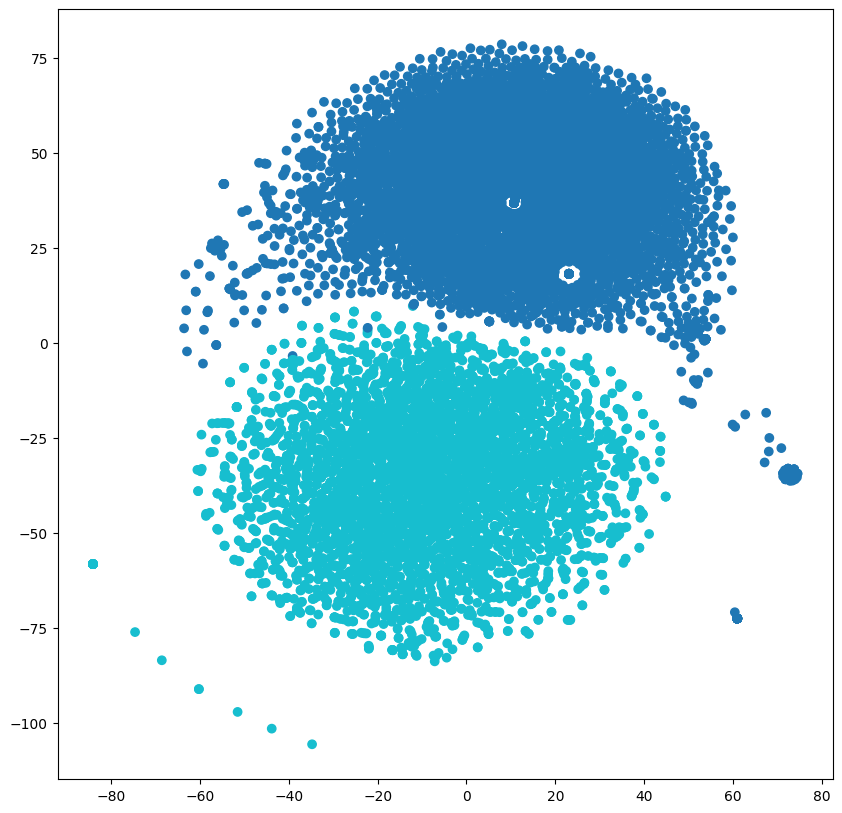

In [ ]:
# Initialize a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the training data using the TF-IDF vectorizer
X_train = vectorizer.fit_transform(mydata_train_trimmed['clean_title'])

# Combine the TF-IDF features with the '2_way_label' column and convert to a NumPy array
X_combined = np.hstack([X_train.toarray(), np.array(mydata_train_trimmed['2_way_label']).reshape(-1, 1)])

# Initialize t-SNE (t-distributed stochastic neighbor embedding) with 2 components
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the combined data using t-SNE
X_tsne = tsne.fit_transform(X_combined)

# Set up a Matplotlib figure for plotting
plt.figure(figsize=(10, 10))

# Scatter plot the t-SNE-transformed data points with color-coded labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mydata_train_trimmed['2_way_label'], cmap='tab10')

# Display the plot
plt.show()

# Pre-process the Data and Build the Model

In [ ]:
def process_data(data_frame):
    texts = []
    labels = []

    for i in range(len(data_frame.clean_title)):
        text = str(data_frame['clean_title'][i])
        texts.append(text)
        labels.append(data_frame['2_way_label'][i])

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index

    print('Found %s unique tokens.' % len(word_index))

    # Pad sequences to ensure consistent length
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Convert labels to categorical format
    labels= to_categorical(np.asarray(labels, dtype='int32'), num_classes=2)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    return data,labels, tokenizer.word_index


# Process data for mydata_test_2 in-place
mydata_train_2_data,mydata_train_2_labels,mydata_train_2_word_index  = process_data(mydata_train_2)

# Process data for mydata_validation_2 in-place
mydata_validation_2_data,mydata_validation_2_labels, mydata_validation_2_word_index = process_data(mydata_validation_2)



Found 147733 unique tokens.
Shape of data tensor: (878218, 1000)
Shape of label tensor: (878218, 2)
Found 45787 unique tokens.
Shape of data tensor: (92444, 1000)
Shape of label tensor: (92444, 2)


In [ ]:
GLOVE_DIR = ""
embeddings_index = {}
fake = open(os.path.join(GLOVE_DIR, '/content/drive/MyDrive/nlp_project/glove.6B.100d.txt'), encoding="utf8")
for line in fake:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
fake.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(mydata_train_2_word_index) + 1, EMBEDDING_DIM))
for word, i in mydata_train_2_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(mydata_train_2_word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer= Constant(embedding_matrix), trainable=False)

Total 400000 word vectors in Glove.


In [ ]:
mydata_train_2.head()

,clean_title,domain,hasImage,image_url,num_comments,score,2_way_label
0,my walgreens offbrand mucinex was engraved wit...,i.imgur.com,True,https://external-preview.redd.it/WylDbZrnbvZdB...,2.0,12,1
1,,,True,http://i.imgur.com/yxrkYT8.jpg,NaN,5,0
2,this concerned sink with a tiny hat,i.redd.it,True,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,2.0,119,0
3,hackers leak emails from uae ambassador to us,aljazeera.com,True,https://external-preview.redd.it/6fNhdbc6K1vFA...,1.0,44,1
4,,,True,http://i.imgur.com/M8KTWMx.jpg,NaN,3,0


The provided Keras model is designed for binary classification. It incorporates a combination of convolutional layers for capturing local patterns, a Long Short-Term Memory (LSTM) layer for handling sequential dependencies, and dense layers for feature aggregation. Dropout and batch normalization are applied to enhance regularization and training stability. The model architecture is characterized by an embedding layer, followed by a series of convolutional and LSTM layers, and concludes with fully connected layers leading to a softmax output for binary classification. The model is compiled using binary cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric.

In order to arrive at the below model architecture we have started with a basic model architecture containing an embedding layer and a drop out layer and some convolution and a Dense layer. Training the model with such architecture resulted in an underfitting of the data. In order to avoid the Underfitting we have increased the number of dense layers and retrained the model but still it was giving the same results as above. To further make the model more generalized added an another convolution layer along with the max-pooling layer and retrained the model with this architecture model started performing better compared with the previous architecture. To further make it better we have added an LSTM and a also added a batch normalization layer to avoid over-fitting. As we expiremented with different model architectures we started getting better results.

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras import layers

# Set the length of the embedding vector
embedding_vecor_length = 32

# Create a Sequential model
model = Sequential()

# Add an embedding layer (assuming 'embedding_layer' is defined elsewhere)
model.add(embedding_layer)

# Apply dropout for regularization
model.add(Dropout(0.2))

# Add the first convolutional layer with 32 filters, kernel size 3, and ReLU activation
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add the second convolutional layer with 64 filters, kernel size 4, and sigmoid activation
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='sigmoid'))
model.add(MaxPooling1D(pool_size=2))

# Add the third convolutional layer with 128 filters, kernel size 5, and ReLU activation
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add an LSTM layer with 100 units, ReLU activation, and dropout for regularization
model.add(LSTM(100, activation='relu', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0.2))

# Apply batch normalization for stability
model.add(BatchNormalization())

# Add dense layers with decreasing units and dropout for regularization
model.add(Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

# Add the output layer with softmax activation for binary classification
model.add(Dense(2, activation='softmax'))

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         14773400  
                                                                 
 dropout_24 (Dropout)        (None, None, 100)         0         
                                                                 
 conv1d_12 (Conv1D)          (None, None, 32)          9632      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, None, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, None, 64)          8256      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, None, 64)          0         
 ng1D)                                                

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# Model checkpoint to save the best model
filepath = "/content/drive/MyDrive/nlp_project/model.h5"  # Location to save your model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# Early stopping to stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks_list = [checkpoint, early_stopping]

# Mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

with tf.device('/device:GPU:0'):
    history = model.fit(
        mydata_train_2_data,
        mydata_train_2_labels,
        validation_split=0.05,
        epochs=9,
        batch_size=2048,  # Increased batch size
        callbacks=callbacks_list
    )

Epoch 1/9
408/408 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.7789
Epoch 1: loss improved from inf to 0.45855, saving model to /content/drive/MyDrive/nlp_project/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 283s 674ms/step - loss: 0.4586 - accuracy: 0.7789 - val_loss: 0.4684 - val_accuracy: 0.8074
Epoch 2/9
408/408 [==============================] - ETA: 0s - loss: 0.4110 - accuracy: 0.8116
Epoch 2: loss improved from 0.45855 to 0.41098, saving model to /content/drive/MyDrive/nlp_project/model.h5
408/408 [==============================] - 281s 688ms/step - loss: 0.4110 - accuracy: 0.8116 - val_loss: 0.3949 - val_accuracy: 0.8190
Epoch 3/9
408/408 [==============================] - ETA: 0s - loss: 0.3974 - accuracy: 0.8197
Epoch 3: loss improved from 0.41098 to 0.39741, saving model to /content/drive/MyDrive/nlp_project/model.h5
408/408 [==============================] - 281s 690ms/step - loss: 0.3974 - accuracy: 0.8197 - val_loss: 0.4036 - val_accuracy: 0.8133
Epoch 4/9
408/408 [==============================] - ETA: 0s - loss: 0.3892 - accuracy: 0.8240
Epoch 4: loss improved from 0.39741 to 0.38916, saving model to /content/drive/MyDrive/nlp_pro

# Model Validation



In [ ]:
val_pred=model.predict(mydata_validation_2_data)

2889/2889 [==============================] - 105s 36ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

predicted_labels = np.argmax(val_pred, axis=1)


precision = precision_score(mydata_validation_2['2_way_label'], predicted_labels, average='weighted')
recall = recall_score(mydata_validation_2['2_way_label'], predicted_labels, average='weighted')
accuracy = accuracy_score(mydata_validation_2['2_way_label'], predicted_labels)
f1 = f1_score(mydata_validation_2['2_way_label'], predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)


Precision: 0.6924065957028182
Recall: 0.6895742287222535
Accuracy: 0.6895742287222535
F1 Score: 0.6830496012640361


In [ ]:
# Function to plot metrics
def plot_metrics(history):
    # Plotting accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

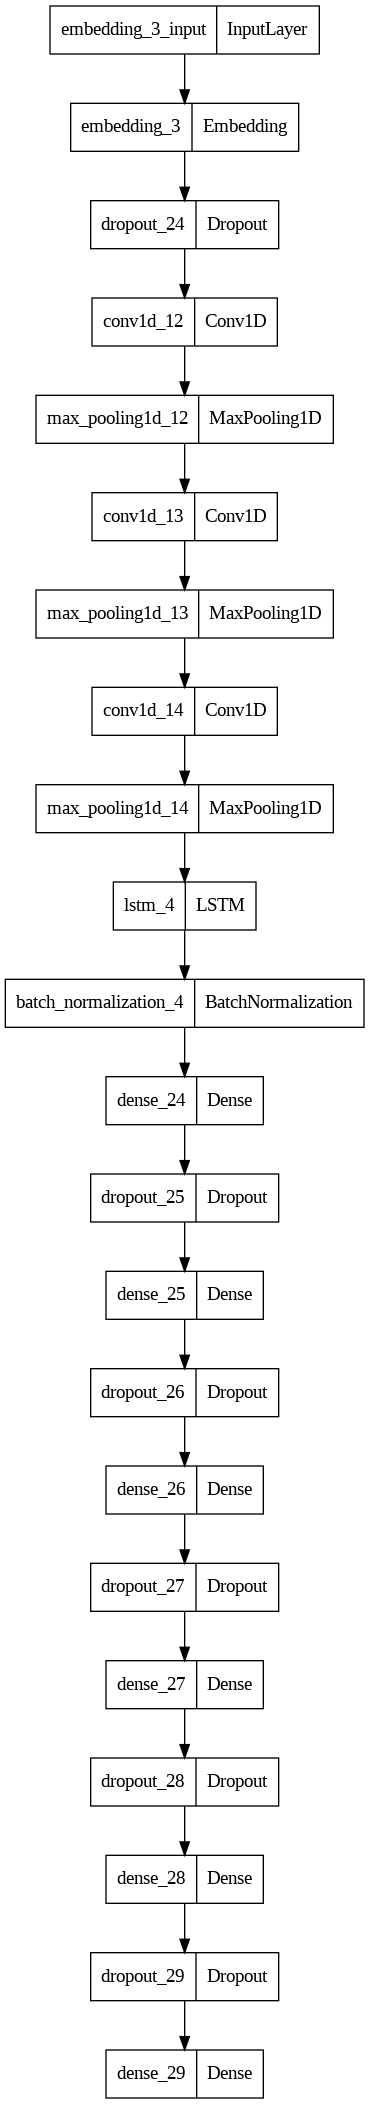

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/nlp_project/new_model.png')

In [ ]:
# model = keras.models.load_model('/content/drive/MyDrive/nlp_project/model.h5')

In [ ]:
roc_auc = roc_auc_score(mydata_validation_2_labels, val_pred)
print("ROC AUC Score:", roc_auc)


ROC AUC Score: 0.7797113474139878


In [ ]:
val_pred_1 = pd.DataFrame(data = (val_pred))
val_pred_1
val_pred_1.columns = ['False','True']
val_pred_1.columns

Index(['False', 'True'], dtype='object')

In [ ]:
val_pred_1['Prediction'] = ""
for i in range(len(val_pred_1)):
  if(val_pred_1['IsFake'][i]==False):
    val_pred_1['Prediction'][i]="Real"
  else:
    val_pred_1['Prediction'][i]="Fake"

<ipython-input-101-d7add2938fe8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_pred_1['Prediction'][i]="Fake"
<ipython-input-101-d7add2938fe8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_pred_1['Prediction'][i]="Real"


In [ ]:
val_pred_1

,False,True,IsFake,Prediction
0,0.999998,0.000002,True,Fake
1,0.875091,0.124909,True,Fake
2,0.934069,0.065931,True,Fake
3,0.942953,0.057047,True,Fake
4,0.472012,0.527988,False,Real
...,...,...,...,...
92439,0.768944,0.231056,True,Fake
92440,0.033284,0.966716,False,Real
92441,0.122467,0.877533,False,Real
92442,0.983434,0.016566,True,Fake


# Train the above Dataset using a Pre-Trained Bert Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, concatenate, LSTM, Bidirectional, Embedding, Flatten,
    GlobalMaxPooling1D, Dropout, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Assuming df is your DataFrame
# For simplicity, let's assume "title" is your text column, and others are numerical features

# Tokenize and embed text data using BERT
max_len = 50  # Maximum length of a title sequence

def embed_text_with_bert(texts):
    embeddings_list=[]

    for i in tqdm(range(0, len(texts), 40), desc="Tokenizing and Embedding Text with BERT"):
        batch_texts = texts[i:i + 40].tolist()
        encoding = tokenizer(batch_texts, max_length=max_len, padding='max_length', truncation=True, return_tensors='tf')
        embeddings = bert_model([encoding['input_ids'], encoding['attention_mask']])[0][:, 0, :]
        embeddings_list.append(embeddings)

    embeddings = tf.concat(embeddings_list, axis=0)
    flattened_embeddings = tf.reshape(embeddings, (embeddings.shape[0], -1)).numpy().tolist()

    return flattened_embeddings

df = mydata_train[['clean_title', '2_way_label', 'num_comments', 'subreddit', 'score']].iloc[:100000, :].dropna()

X_text_bert = embed_text_with_bert(df['clean_title'])

# Numerical feature scaling
scaler = StandardScaler()
X_numerical = scaler.fit_transform(df[['num_comments', 'score']])

# Assuming 'subreddit_name' is a categorical feature
X_subreddit = pd.get_dummies(df['subreddit'], drop_first=True)

# Combine all features for both models
X_combined_bert = np.concatenate([X_text_bert, X_numerical, X_subreddit], axis=1)

# Model using BERT
text_input_bert = Input(shape=(768,))  # 768 is the dimension of BERT embeddings
dense_layer_text_bert = Dense(512, activation='relu')(text_input_bert)
dense_layer_text_bert = Dropout(0.5)(dense_layer_text_bert)
dense_layer_text_bert = LayerNormalization()(dense_layer_text_bert)

numerical_input_bert = Input(shape=(X_numerical.shape[1],))
subreddit_input_bert = Input(shape=(X_subreddit.shape[1],))

merged_bert = concatenate([dense_layer_text_bert, numerical_input_bert, subreddit_input_bert])
dense_layer_bert = Dense(256, activation='relu')(merged_bert)
dense_layer_bert = Dropout(0.5)(dense_layer_bert)
dense_layer_bert = LayerNormalization()(dense_layer_bert)

output_bert = Dense(1, activation='sigmoid')(dense_layer_bert)

model_bert = Model(inputs=[text_input_bert, numerical_input_bert, subreddit_input_bert], outputs=output_bert)
model_bert.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Split data into train and test sets
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_combined_bert, df['2_way_label'], test_size=0.2, random_state=42)
# Train the models
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train BERT model
model_bert.fit(x=[X_train_bert[:, :768], X_train_bert[:, 768:770], X_train_bert[:, 770:770+X_subreddit.shape[1]]],
               y=y_train_bert,
               epochs=30,
               batch_size=64,
               validation_data=([X_test_bert[:, :768], X_test_bert[:, 768:770], X_test_bert[:, 770:770+X_subreddit.shape[1]]], y_test_bert),
               callbacks=[early_stopping])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/30
907/907 [==============================] - 7s 5ms/step - loss: 0.2283 - accuracy: 0.8973 - val_loss: 1.7889e-04 - val_accuracy: 0.9999
Epoch 2/30
907/907 [==============================] - 4s 5ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 2.8373e-05 - val_accuracy: 1.0000
Epoch 3/30
907/907 [==============================] - 5s 5ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 6.6290e-06 - val_accuracy: 1.0000
Epoch 4/30
907/907 [==============================] - 4s 5ms/step - loss: 5.3371e-04 - accuracy: 0.9999 - val_loss: 2.8879e-06 - val_accuracy: 1.0000
Epoch 5/30
907/907 [==============================] - 4s 5ms/step - loss: 3.6273e-04 - accuracy: 0.9999 - val_loss: 2.5754e-05 - val_accuracy: 1.0000
Epoch 6/30
907/907 [==============================] - 4s 5ms/step - loss: 2.9787e-04 - accuracy: 0.9999 - val_loss: 2.0785e-06 - val_accuracy: 1.0000
Epoch 7/30
907/907 [==============================] - 4s 5ms/step - loss: 7.7521e-05 - accuracy: 1.0000 - val_lo

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Function to get precision, recall, and f1-score
def get_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

# Predictions on the test set for both models
y_pred_bert = (model_bert.predict([X_test_bert[:, :768], X_test_bert[:, 768:770], X_test_bert[:, 770:770+X_subreddit.shape[1]]]) > 0.5).astype(int)

# Get metrics for BERT model
accuracy_bert, precision_bert, recall_bert, f1_bert = get_metrics(y_test_bert, y_pred_bert)
print("BERT Model - Accuracy:", accuracy_bert)
print("BERT Model - Precision:", precision_bert)
print("BERT Model - Recall:", recall_bert)
print("BERT Model - F1-Score:", f1_bert)

454/454 [==============================] - 1s 2ms/step
BERT Model - Accuracy: 1.0
BERT Model - Precision: 1.0
BERT Model - Recall: 1.0
BERT Model - F1-Score: 1.0
